<a href="https://colab.research.google.com/github/JSJeong-me/GPT-Insights/blob/main/10-Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CSV 데이터는 10만 건의 시계열 로그로 구성되어 있고, 주요 컬럼은 다음과 같습니다:

* **리소스 모니터링**: `CPU_usage`, `Memory_usage`
* **센서·설비 상태**: `Fire_Signal`, `Leak_Detector`, `Generator`, `Transformer`, `Circuit_Breaker`, `Emergency_Alarm`, `Jet_Fan` 등
* **부가 제어 데이터**: `Dimming_Controller`, `Lighting_Controller`, `Anemometer`, `CCTV_Load`, `Delay_Time_ms`
* **라벨**: `Anomaly` (0=정상, 1=이상)

---

### 🔎 Feature 분석 및 이상 상황 분류 정리

#### 1. **데이터 전처리**

* `Unnamed:0` → 타임스탬프로 보임 (`2024-01-01 00:00:00` 형식). `datetime` 변환 후 index로 활용 가능.
* 결측치 없음 → 바로 분석 가능.

#### 2. **이상 상황 정의 (조건 기반 Rule)**

이상 레이블(`Anomaly`)은 다음 조건과 관련:

* **CPU 사용률 ≥ 85%**
* **메모리 사용률 ≥ 90%**
* **Fire\_Signal == 1**
* **Emergency\_Alarm == 1**
* (추가적으로 전력 설비, 제어 장치의 극단값도 고려 가능)

→ 조건이 하나라도 충족되면 `Anomaly = 1` 로 레이블링된 것으로 추정됨.

#### 3. **Feature별 기여도 확인**

* **CPU\_usage**: 고사용률 순간에 `Anomaly` 발생 비율 상승 예상.
* **Memory\_usage**: 90% 이상일 때 `Anomaly` 집중.
* **Fire\_Signal, Emergency\_Alarm**: binary 변수 → 켜지는 순간 무조건 Anomaly 연계.
* **Delay\_Time\_ms**: 지연 시간 급증 시 이상과 상관관계 가능 (네트워크 문제).
* **Transformer, Load\_Switch, Circuit\_Breaker**: 전력 장치의 on/off 여부가 Anomaly 상황을 강화할 수 있음.

#### 4. **분석 접근 방법**

* **조건 검증**: 정의된 기준(85%, 90%, Fire, Alarm 등)이 실제로 `Anomaly`와 얼마나 일치하는지 교차검증.
* **Feature importance**: Random Forest, XGBoost 등으로 학습 → 어떤 feature가 이상 탐지에 가장 큰 기여하는지 분석.
* **시계열 패턴 분석**: Anomaly 직전 CPU/Memory 추세를 시각화 → 급격한 상승 or 특정 패턴이 있는지 확인.

#### 5. **활용 시나리오**

* **실시간 이상 감지**: 조건 기반 규칙 + ML 기반 anomaly score 결합.
* **설비 안전 관리**: Fire\_Signal, Emergency\_Alarm이 트리거되면 즉시 대응.
* **자원 모니터링 최적화**: CPU/Memory 이상 패턴 조기 탐지로 edge device 안정성 강화.

---

👉 **리소스 임계치(85% CPU, 90% 메모리) + 안전설비 트리거(Fire, Alarm)**


조건 기반 anomaly 데이터 수: 10969


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


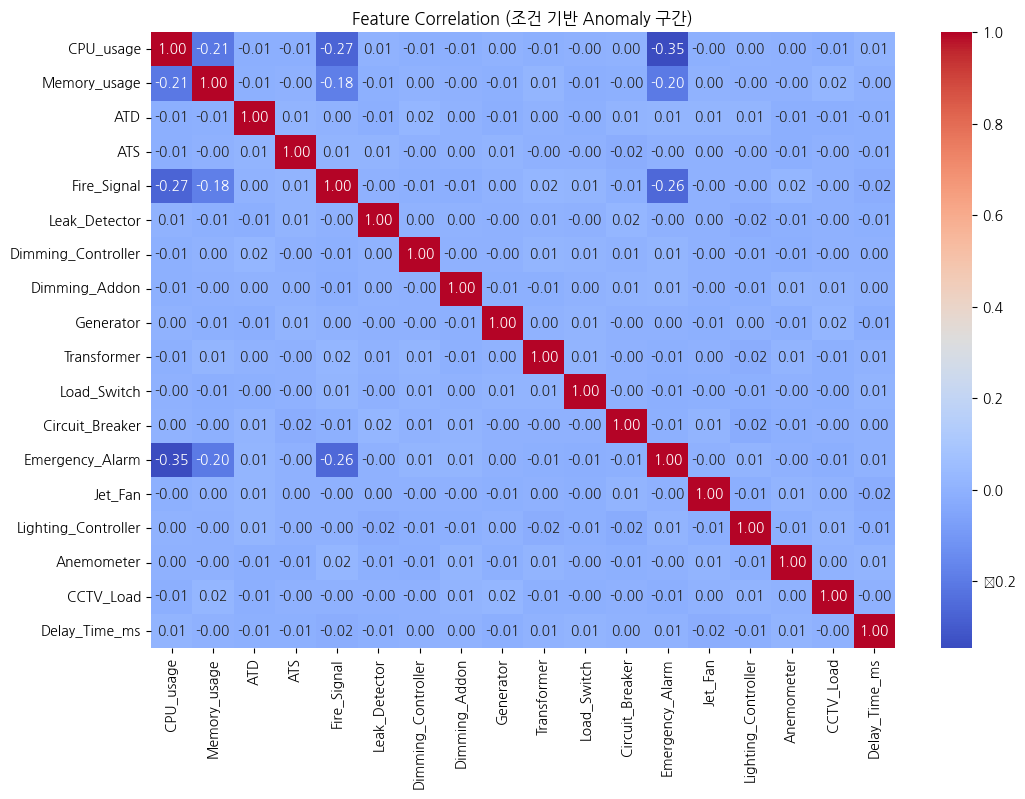

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CSV 불러오기
file_path = "/content/Edge_Device_Training_Data.csv"
df = pd.read_csv(file_path)

# timestamp 컬럼 정리
df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])
df = df.drop(columns=['Unnamed: 0'])

# 조건 기반 anomaly 구간 필터링
condition = (
    (df['CPU_usage'] >= 85) |
    (df['Memory_usage'] >= 90) |
    (df['Fire_Signal'] == 1) |
    (df['Emergency_Alarm'] == 1)
)
anomaly_df = df[condition & (df['Anomaly'] == 1)]

print(f"조건 기반 anomaly 데이터 수: {len(anomaly_df)}")

# 수치형 feature만 선택
numeric_cols = anomaly_df.select_dtypes(include=['float64', 'int64']).drop(columns=['Anomaly']).columns

# 상관계수 계산
corr_matrix = anomaly_df[numeric_cols].corr()

# 상관분석 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation (조건 기반 Anomaly 구간)", fontfamily='NanumGothic')
plt.show()

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')